In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import yaml
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, AutoEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from dwave_networkx.algorithms.coloring import min_vertex_color, is_vertex_coloring
import time
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
from graphilp.partitioning import min_vertex_coloring as vtx
from graphilp.imports import networkx as imp_nx

In [50]:
#q_sampler = AutoEmbeddingComposite(DWaveSampler(token='DEV-076b8a03c140ad9291e859ef02ab3403afc91429'))

#### Generate Network 

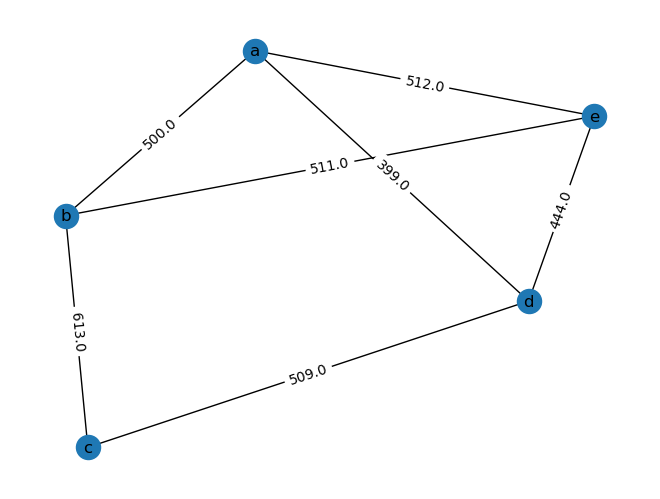

In [51]:
def plot_graph(filename):

    G = nx.read_weighted_edgelist(filename)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()
    return G
G=plot_graph("networks/graph3.txt")

#### Generate Network Demands

In [52]:
def generate_demands(G):
    demands = {}
    for a in G.nodes:
        for b in G.nodes:
            if b == a:
                pass
            else:
                x = random.randrange(0, 3, 1)
                if x == 0:
                    demands[(a, b)] = 10
                elif x == 1:
                    demands[(a, b)] = 40
                else:
                    demands[(a, b)] = 100
    return demands
#demands={('a', 'b'): 40, ('a', 'c'): 10, ('a', 'd'): 100, ('b', 'a'): 10, ('b', 'c'): 100, ('b', 'd'): 100, ('c', 'a'): 100, ('c', 'b'): 100, ('c', 'd'): 100, ('d', 'a'): 100, ('d', 'b'): 10, ('d', 'c'): 100}
demands=generate_demands(G)
print(demands)
#4-demands={('a', 'b'): 40, ('a', 'e'): 40, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'a'): 10, ('b', 'e'): 40, ('b', 'c'): 40, ('b', 'd'): 10, ('e', 'a'): 100, ('e', 'b'): 100, ('e', 'c'): 40, ('e', 'd'): 100, ('c', 'a'): 10, ('c', 'b'): 100, ('c', 'e'): 40, ('c', 'd'): 100, ('d', 'a'): 10, ('d', 'b'): 100, ('d', 'e'): 100, ('d', 'c'): 10}
demands={('a', 'b'): 40, ('a', 'e'): 100, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'a'): 10, ('b', 'e'): 100, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'a'): 10, ('e', 'b'): 10, ('e', 'c'): 40, ('e', 'd'): 40, ('c', 'a'): 100, ('c', 'b'): 100, ('c', 'e'): 100, ('c', 'd'): 40, ('d', 'a'): 10, ('d', 'b'): 40, ('d', 'e'): 10, ('d', 'c'): 10}

{('a', 'b'): 10, ('a', 'e'): 40, ('a', 'c'): 10, ('a', 'd'): 40, ('b', 'a'): 100, ('b', 'e'): 40, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'a'): 40, ('e', 'b'): 40, ('e', 'c'): 40, ('e', 'd'): 40, ('c', 'a'): 100, ('c', 'b'): 40, ('c', 'e'): 100, ('c', 'd'): 40, ('d', 'a'): 10, ('d', 'b'): 10, ('d', 'e'): 40, ('d', 'c'): 10}


In [53]:
#demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'a'): 40, ('b', 'e'): 10, ('b', 'f'): 40, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'a'): 100, ('e', 'b'): 100, ('e', 'f'): 100, ('e', 'c'): 40, ('e', 'd'): 100, ('f', 'a'): 100, ('f', 'b'): 40, ('f', 'e'): 100, ('f', 'c'): 10, ('f', 'd'): 100, ('c', 'a'): 40, ('c', 'b'): 100, ('c', 'e'): 100, ('c', 'f'): 100, ('c', 'd'): 40, ('d', 'a'): 40, ('d', 'b'): 100, ('d', 'e'): 100, ('d', 'f'): 10, ('d', 'c'): 40}
cropped_demands={}
for item in demands:
    if item[1]>item[0]:
        cropped_demands[item]=demands[item]
print(cropped_demands)
#1-demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'e'): 40, ('b', 'f'): 40, ('b', 'c'): 10, ('b', 'd'): 10, ('e', 'f'): 10, ('c', 'e'): 10, ('c', 'f'): 100, ('c', 'd'): 100, ('d', 'e'): 100, ('d', 'f'): 40}
#2-demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'e'): 10, ('b', 'f'): 40, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'f'): 100, ('c', 'e'): 100, ('c', 'f'): 100, ('c', 'd'): 40, ('d', 'e'): 100, ('d', 'f'): 10}
#3-demands={('a', 'b'): 40, ('a', 'e'): 40, ('a', 'f'): 40, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'e'): 100, ('b', 'f'): 100, ('b', 'c'): 10, ('b', 'd'): 10, ('e', 'f'): 10, ('c', 'e'): 10, ('c', 'f'): 40, ('c', 'd'): 10, ('d', 'e'): 10, ('d', 'f'): 100}

{('a', 'b'): 40, ('a', 'e'): 100, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'e'): 100, ('b', 'c'): 100, ('b', 'd'): 40, ('c', 'e'): 100, ('c', 'd'): 40, ('d', 'e'): 10}


#### Generate transformed graph

46


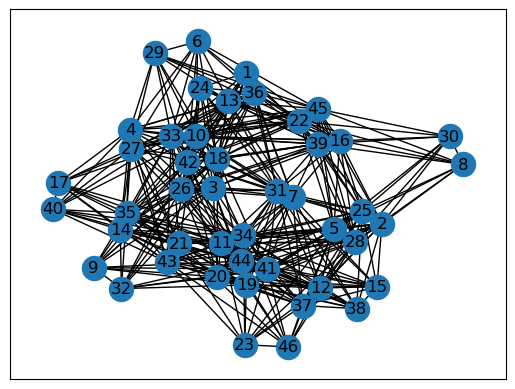

In [54]:
def create_graph(filepath, Graph, demands):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    converted_graph = nx.Graph()
    s_d_label = 0
    label = 0
    for a in network_data:
        s_d_label += 1
        source = network_data[a]["source"]
        destination = network_data[a]["destination"]
        rate = demands[(source, destination)]
        for i in network_data[a]["routes"]:
            label += 1
            nodes_in_path = i
            edges_in_path = []
            total_weight = 0
            for j in range(len(i) - 1):
                edges_in_path.append((nodes_in_path[j], nodes_in_path[j + 1]))
                edges_in_path.append((nodes_in_path[j+1], nodes_in_path[j])) # remove if direction of light matters.
                total_weight += Graph[nodes_in_path[j]][nodes_in_path[j + 1]]["weight"]
            converted_graph.add_node(label, s_d=s_d_label, r=rate,w=total_weight,edges=edges_in_path)
    x=converted_graph.number_of_nodes()
    for a in range(1,x):
        for b in range(a+1,x+1):
            if converted_graph.nodes[a]["s_d"] != converted_graph.nodes[b]["s_d"]: # don't want connection between same routes- then each one affects the others selection
                for j in converted_graph.nodes[a]["edges"]:
                    for i in converted_graph.nodes[b]["edges"]:
                        if i == j:
                            converted_graph.add_edge(a,b)
                            break
                    else:
                        continue
                    break
                        
                        
    return converted_graph

new_graph=create_graph("networks/graph3-conversion.yaml",G,demands)
nx.draw_networkx(new_graph)
number_of_nodes=len(new_graph.nodes)
print(number_of_nodes)

#### Write QUBO formualtion

In [55]:
def create_qubo(Graph,c1,c2,c3,c4):
    Q={}
    adj_matrix=nx.adjacency_matrix(Graph)
    dense_matrix=adj_matrix.todense()
    set_of_nodes=Graph._node
    for a in set_of_nodes:
        for b in set_of_nodes:
            if Graph.nodes[a]["s_d"]==Graph.nodes[b]["s_d"]:
                if a==b:
                    Q[(a,b)]=-c1
                else:
                    Q[(a,b)]=2*c1
            elif dense_matrix[a-1][b-1]==1:
                Q[(a,b)]=c2
            else:
                Q[(a,b)]=0
    
    for a in set_of_nodes:
        length=Graph.nodes[a]["w"]  
        Q[(a,a)]+=c4*length
        if Graph.nodes[a]["r"]==10:
            max_d=1680
        elif Graph.nodes[a]["r"]==40:
            max_d=1170
        else:
            max_d=1060
        if length>max_d:
            Q[(a,a)]+=c3


    return Q
            
QUBO = create_qubo(new_graph,1.5,0,2,0)
bqm= BinaryQuadraticModel.from_qubo(QUBO)

#### Solve with Gurobi  

In [56]:
def solve_qubo_with_gurobi(Q):
    # Create a Gurobi model
    model = Model("QUBO")

    # Suppress Gurobi output
    model.setParam('OutputFlag', 0)

    # Extract variables from QUBO keys
    variables = set(i for i, j in Q.keys()).union(set(j for i, j in Q.keys()))

    # Add binary variables to the model
    x = {v: model.addVar(vtype=GRB.BINARY, name=f'x_{v}') for v in variables}

    # Add the QUBO objective function
    model.setObjective(
        quicksum(Q[i, j] * x[i] * x[j] for i, j in Q.keys()),
        GRB.MINIMIZE
    )
    # Measure the runtime
    start_time = time.time()
    model.optimize()
    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time


    # Extract the solution
    if model.status == GRB.OPTIMAL:
        solution = {v: int(x[v].x) for v in variables}
        objective_value = model.objVal
        return solution, objective_value,runtime
    else:
        return None, None
gurobi_sol=solve_qubo_with_gurobi(QUBO)
print(gurobi_sol)

({1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 0, 20: 0, 21: 1, 22: 0, 23: 1, 24: 0, 25: 1, 26: 0, 27: 1, 28: 0, 29: 1, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 0, 37: 0, 38: 0, 39: 1, 40: 0, 41: 0, 42: 1, 43: 0, 44: 1, 45: 0, 46: 1}, -30.0, 0.0)


In [57]:
gurobi_table=[]
for i in range(1,number_of_nodes+1):
    gurobi_table.append(gurobi_sol[0][i])
print(gurobi_table)


[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1]


#### Solve with QA 

In [58]:
def solve_qubo(bqm,sampler=SimulatedAnnealingSampler(),num_runs=1):
    sampleset= sampler.sample(bqm,num_reads=num_runs,label= "Routing QUBO solving")
    return sampleset

result=solve_qubo(bqm)
print(result)
for variable in range(1,number_of_nodes+1):
    print(int(result.first.sample[variable]))

   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 ... 46 energy num_oc.
0  0  1  0  1  0  1  1  0  1  0  0  0  0  1  0  1  1  0 ...  1  -30.0       1
['BINARY', 1 rows, 1 samples, 46 variables]
0
1
0
1
0
1
1
0
1
0
0
0
0
1
0
1
1
0
0
0
1
1
0
0
1
0
1
1
0
0
1
1
0
0
1
0
0
0
1
0
1
0
1
0
0
1


#### Check if solution is valid

In [59]:
def is_valid_solution(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=[]
    total_length=0
    for i in range(1,number_of_nodes+1):
        solution_results.append(int(result.first.sample[i]))
        if int(result.first.sample[i])==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]

def is_valid_solution_gurobi(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=result
    total_length=0
    for i in range(1,number_of_routes[-1]+1):
        if solution_results[i-1]==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]
    
print(is_valid_solution(result,"networks/graph3-conversion.yaml",new_graph))
print(is_valid_solution_gurobi(gurobi_table,"networks/graph3-conversion.yaml",new_graph))


[True, 18071.0]
[True, 16496.0]


#### Is solution same as Gurobi solution

In [1206]:
solution_values=[]
for variable in range(1,number_of_nodes+1):
    solution_values.append(int(result.first.sample[variable]))
print(solution_values==gurobi_table)
for variable in range(1,number_of_nodes+1):
    if not solution_values[variable-1]==gurobi_table[variable-1]:
        print(variable)

False
1
2
4
5
6
24
25
28
29
30
31
35
37
38
39
40
42
43
44
46


#### SA accuracy test

In [1169]:
QUBO = create_qubo(new_graph,4.5,0.11,4.5,0.0022)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=gurobi_table
runs=100
solved_cases=0
time_taken=0
optimal_solves=0
colour_dic_SA={}
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if is_valid_solution(solution,"networks/graph3-conversion.yaml",new_graph)[0]:
        solved_cases+=1
        graph=new_graph.copy()
        for i in range(number_of_nodes-1):
            if solution_outcomes[i]==0:
                graph.remove_node(i+1)
        coloured=solve_graph_coloring_networkx(graph)
        if coloured["num_colors"] in colour_dic_SA:
            colour_dic_SA[coloured["num_colors"]]+=1
        else:
            colour_dic_SA[coloured["num_colors"]]=1
    if solution_outcomes==correct_solution:
        optimal_solves+=1
    

print(solved_cases/runs,optimal_solves/runs,time_taken/runs,colour_dic_SA) 

1.0 0.37 0.007231100993230939 {6: 26, 5: 74}


#### QA accuracy test

In [1207]:
QUBO = create_qubo(new_graph,1.5,0,2,0)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=gurobi_table
saved_solutions=[]
runs=100
solved_cases=0
time_taken=0
optimal_solves=0
colour_dic={}
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm,q_sampler)
    saved_solutions.append(solution)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if is_valid_solution(solution,"networks/graph1-conversion.yaml",new_graph)[0]:
        solved_cases+=1
        graph=new_graph.copy()
        for i in range(number_of_nodes):
            if solution_outcomes[i]==0:
                graph.remove_node(i+1)
        coloured=solve_graph_coloring_networkx(graph)
        if coloured["num_colors"] in colour_dic:
            colour_dic[coloured["num_colors"]]+=1
        else:
            colour_dic[coloured["num_colors"]]=1 
    if solution_outcomes==correct_solution:
        optimal_solves+=1
    

print(solved_cases/runs,optimal_solves/runs,time_taken/runs,colour_dic) 

0.0 0.0 9.9591610279819 {}


#### Generate reduced graph

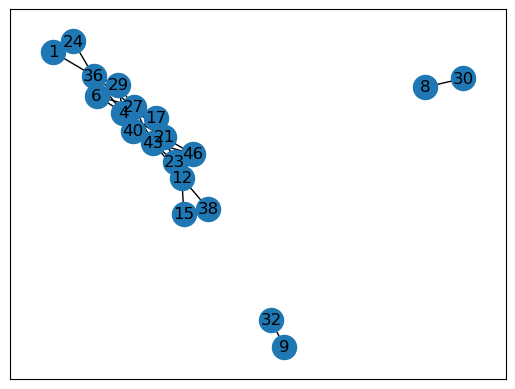

In [1118]:

for i in range(number_of_nodes):
    if solution_values[i]==0:
        new_graph.remove_node(i+1)


nx.draw_networkx(new_graph)

### Graph Colouring Gurobi

In [1119]:
def solve_graph_coloring_gurobi(Graph):
    edges = list(Graph.edges)
    G = imp_nx.read(Graph)
    # List of edges (each edge represented as a tuple of nodes)
    

    # Create a Gurobi environment with output suppressed
    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)  # Suppress output
    env.start()
    
    # Create the model using vtx.create_model
    mdl = vtx.create_model(G)

    # Optimize the model
    start_time = time.time()
    mdl.optimize()
    end_time = time.time()

    # Extract the solution using the provided function
    color_to_node, node_to_color = vtx.extract_solution(G, mdl)

    if mdl.status == GRB.OPTIMAL:
        # Use the extracted solution to build the color_map
        color_map = {node: color for color, nodes in color_to_node.items() for node in nodes}
        used_colors = set(color_map.values())

        # Verify that no two adjacent nodes have the same color
        valid = True
        for (i, j) in edges:
            if color_map[i] == color_map[j]:
                valid = False
                break  # No need to continue if an invalid pair is found

        return {
            "valid": valid,
            "num_colors": len(used_colors),
            "time_taken": end_time - start_time
        }
    else:
        return {
            "valid": False,
            "num_colors": None,
            "time_taken": end_time - start_time
        }

solve_graph_coloring_gurobi(new_graph)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 3 4300U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 859 rows, 420 columns and 2898 nonzeros
Model fingerprint: 0x6bcc233d
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 12.0000000
Presolve removed 760 rows and 194 columns
Presolve time: 0.05s
Presolved: 99 rows, 226 columns, 582 nonzeros
Variable types: 0 continuous, 226 integer (226 binary)

Root relaxation: objective 6.000000e+00, 88 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


{'valid': True, 'num_colors': 6, 'time_taken': 0.13646316528320312}

### LDF Greedy

In [1120]:
def solve_graph_coloring_networkx(G):
    start_time = time.time()
    nx_coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    end_time = time.time()

    nx_colors_used = len(set(nx_coloring.values()))

    return {
        "valid": True,  # Greedy algorithm should provide a valid coloring
        "num_colors": nx_colors_used,
        "time_taken": end_time - start_time
    }
 
solve_graph_coloring_networkx(new_graph)

{'valid': True, 'num_colors': 6, 'time_taken': 0.0010175704956054688}

#### QA to find colouring of generated graph

In [1080]:
def solve_graph_coloring_annealing(G, sampler, attempts=3):
    start_time = time.time()
    for i in range(attempts):        
        solution = min_vertex_color(G, sampler=sampler, label="GCP")
        try:
            if is_vertex_coloring(G, solution):
                end_time = time.time()
                wavelengths = len(set(solution.values()))
                return {
                    "valid": True,
                    "num_colors": wavelengths,
                    "time_taken": end_time - start_time,
                    "solution": solution
                }
            print(f"[-] Attempt {i} failed")
        except KeyError:
            continue
    return "timeout"
colouring=solve_graph_coloring_annealing(new_graph,SimulatedAnnealingSampler())
print(colouring)

{'valid': True, 'num_colors': 6, 'time_taken': 0.016934633255004883, 'solution': {1: 3, 4: 0, 6: 1, 8: 0, 9: 3, 13: 4, 15: 4, 17: 1, 21: 3, 23: 1, 24: 1, 27: 2, 29: 3, 30: 4, 32: 4, 37: 2, 38: 1, 40: 4, 43: 5, 46: 4}}


#### Generate graph of colouring of reduced graph

6


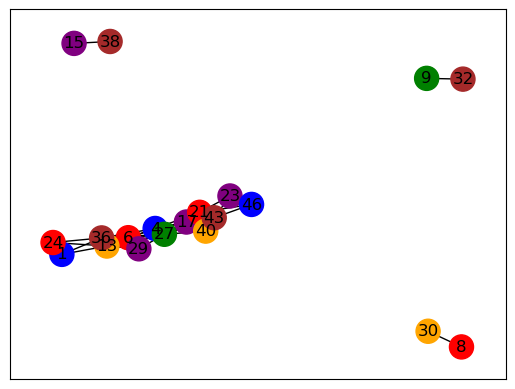

In [1060]:
selected_colours=colouring["solution"]
colours=["blue","red","green","brown","purple","orange","pink","gray","olive","cyan"]
color_map=[]
for a in selected_colours:
    color_map.append(colours[selected_colours[a]])
print(colouring["num_colors"])
nx.draw_networkx(new_graph,node_color=color_map)

#### SA accuracy test

In [ ]:
QUBO = create_qubo(new_graph,1,0.01,3.5)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=gurobi_table
runs=10
solved_cases=0
time_taken=0
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if solution_outcomes==correct_solution:
        solved_cases+=1

print(solved_cases/runs,time_taken/runs)   

#### QA accuracy test

In [ ]:
QUBO = create_qubo(new_graph,1,0.01,3.5)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=gurobi_table
runs=10
solved_cases=0
time_taken=0
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm,q_sampler)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if solution_outcomes==correct_solution:
        solved_cases+=1

print(solved_cases/runs,time_taken/runs) 